In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import gc
import math
import datetime as dt

%matplotlib inline

from sklearn import model_selection, preprocessing, metrics
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Credit to https://www.kaggle.com/sudalairajkumar
gc.enable()

features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source', 'customDimensions']

def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
            converters={column: json.loads for column in JSON_COLUMNS}, 
            dtype={'fullVisitorId': 'str'}, # Important!!
            chunksize=100000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis=0).reset_index(drop=True)
        #print(ans.shape)
    return ans


In [3]:
%%time
train_df = load_df('train_v2.csv')
test_df = load_df('test_v2.csv')

print('train date:', min(train_df['date']), 'to', max(train_df['date']))
print('test date:', min(test_df['date']), 'to', max(test_df['date']))

train date: 20160801 to 20180430
test date: 20180501 to 20181015
CPU times: user 13min 6s, sys: 1min 8s, total: 14min 15s
Wall time: 12min 46s


In [4]:
# Credit to https://www.kaggle.com/gemartin
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 398042601.00 MB
Memory usage after optimization is: 369000872.00 MB
Decreased by 7.3%
Memory usage of dataframe is 93570317.00 MB
Memory usage after optimization is: 86743304.00 MB
Decreased by 7.3%


In [5]:
# Print example User
train_df.iloc[1, :]

channelGrouping                                                        Referral
date                                                                   20171016
fullVisitorId                                               8934116514970143966
visitId                                                              1508176307
visitNumber                                                                   6
visitStartTime                                                       1508176307
device.browser                                                           Chrome
device.deviceCategory                                                   desktop
device.isMobile                                                               0
device.operatingSystem                                                Chrome OS
geoNetwork.city                                                       Cupertino
geoNetwork.continent                                                   Americas
geoNetwork.country                      

In [6]:
# For transactionRevenue fill nan values with 0
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
train_df['totals.transactionRevenue'].fillna(0.0, inplace=True)

test_df["totals.transactionRevenue"] = test_df["totals.transactionRevenue"].astype('float')
test_df['totals.transactionRevenue'].fillna(0.0, inplace=True)

In [7]:
# convert date string to datetime format
train_df['date'] = pd.to_datetime(train_df.date, format="%Y%m%d")
test_df['date'] = pd.to_datetime(test_df.date, format="%Y%m%d")

In [8]:
# Backup dataframes
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

In [146]:
# read backup if needed
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

In [167]:
# Print inital statistics 
print ('Number of rows in train set: ', train_df.shape[0])
print ("Number of visitors in train set: ",train_df.fullVisitorId.nunique())
print ("Number of purchases made in train set: ", len(train_df.loc[train_df['totals.transactionRevenue'] > 0]))
VR = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
print ('Number of customers in train set: ', VR.loc[VR['totals.transactionRevenue'] > 0].count().values[0])
print ('Total amount spent: ', VR['totals.transactionRevenue'].sum())
print ('Mean amount spent:', VR['totals.transactionRevenue'].mean())
print ('Standard deviation:', VR['totals.transactionRevenue'].std())
print ('PCT customers: ', (VR.loc[VR['totals.transactionRevenue'] > 0].count().values[0] / VR.shape[0]) * 100 , '%' )

print ('\nNumber of rows in test set: ', test_df.shape[0])
print ("Number of visitors in test set: ",test_df.fullVisitorId.nunique())
print ("Number of purchases made in test set: ", len(test_df.loc[test_df['totals.transactionRevenue'] > 0]))
VR = test_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()
print ('Total amount spent: ', VR['totals.transactionRevenue'].sum())
print ('Mean amount spent:', VR['totals.transactionRevenue'].mean())
print ('Standard deviation:', VR['totals.transactionRevenue'].std())
print ('PCT customers: ', (VR.loc[VR['totals.transactionRevenue'] > 0].count().values[0] / VR.shape[0]) * 100 , '%' )

print("\nNumber of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))


Number of rows in train set:  1708337
Number of visitors in train set:  1323730
Number of purchases made in train set:  18514
Number of customers in train set:  16141
Total amount spent:  2316344980000.0
Mean amount spent: 1749862.1168969502
Standard deviation: 115399633.82418895
PCT customers:  1.219357421830736 %

Number of rows in test set:  401589
Number of visitors in test set:  296530
Number of purchases made in test set:  4594
Total amount spent:  558347940000.0
Mean amount spent: 1882939.1292617947
Standard deviation: 75361967.48034734
PCT customers:  1.401544531750582 %

Number of common visitors in train and test set :  2759


In [168]:
# Save train date max for later split
train_date_max =  train_df.date.max()
print (train_date_max)

2018-04-30 00:00:00


In [169]:
#set i manually for later use if needed
train_date_max = dt.date(2018, 4,30)

In [170]:
#Merge train and test data for easier handling and feature selection
total_df = pd.concat([train_df, test_df])

In [171]:
#drop columns not included in in model
drop_cols = ['visitId','visitStartTime', 'device.browser',
            'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.metro',
            'geoNetwork.networkDomain', 'geoNetwork.region', 'trafficSource.adContent',
            'trafficSource.keyword', 'trafficSource.referralPath', 'customDimensions','trafficSource.campaign',
            'geoNetwork.country', 'trafficSource.source']

total_df.drop(columns=drop_cols, axis=1, inplace=True)

# Fill each entry with O if na
total_df.fillna(0, inplace=True)

In [172]:
# Select purchases
purch = total_df.loc[total_df['totals.transactionRevenue'] > 0]
non_purch = total_df.loc[total_df['totals.transactionRevenue'] <= 0]

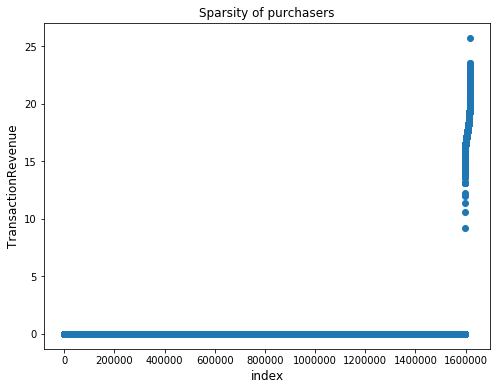

In [50]:
# Visualize sparisty of purchasers 
gdf = total_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.subplot()
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Sparsity of purchasers')
plt.show()

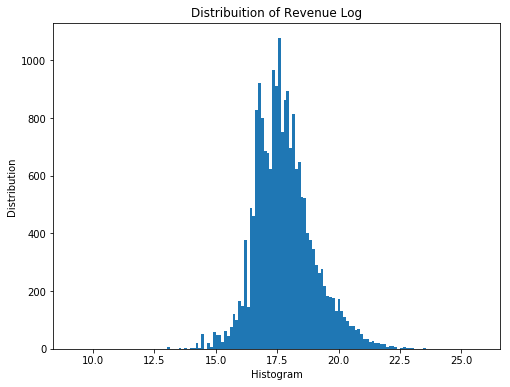

In [51]:
plt.figure(figsize=(8,6))
plt.hist(x=np.log1p(gdf.loc[gdf['totals.transactionRevenue'] > 0, 'totals.transactionRevenue'].values),
         bins='sqrt')
plt.ylabel('Distribution')
plt.xlabel('Histogram')
plt.title('Distribuition of Revenue Log')
plt.show()

Text(0.5, 1.0, 'Count of purchases by subcontinent')

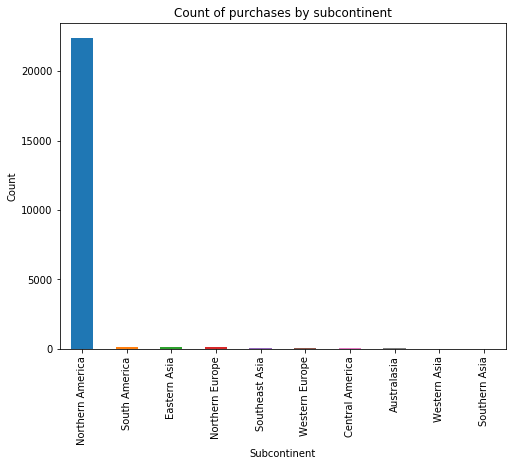

In [52]:
# Plot count of purchases by subcontinent
gr = purch.groupby('geoNetwork.subContinent')['geoNetwork.subContinent'].count()
ax = gr.sort_values(ascending=False).head(10).plot(kind='bar',figsize=(8,6))
ax.set_ylabel('Count')
ax.set_xlabel('Subcontinent')
ax.set_title('Count of purchases by subcontinent')

Text(0.5, 1.0, 'Mean transaction sum by subcontinent')

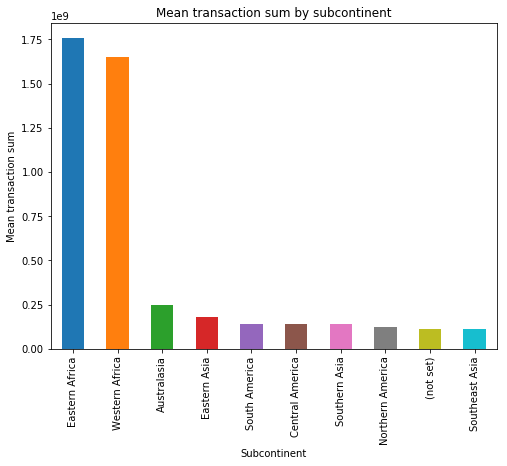

In [53]:
# Plot mean transaction sum subcontinent
gr = purch.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['count', 'mean'])
ax = gr['mean'].sort_values(ascending=False).head(10).plot(kind='bar',figsize=(8,6))
ax.set_ylabel('Mean transaction sum')
ax.set_xlabel('Subcontinent')
ax.set_title('Mean transaction sum by subcontinent')

Text(0.5, 1.0, 'Count of transactions by date')

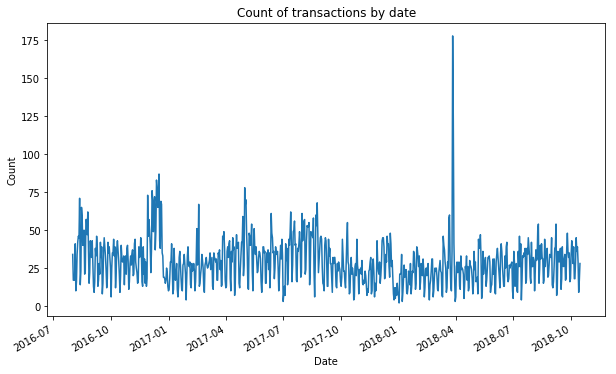

In [54]:
# Plot count of transactions by date
gr_cnt = purch.groupby('date')['totals.transactionRevenue'].agg(['count', 'sum'])
ax = gr_cnt['count'].plot.line(figsize=(10,6))
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Count of transactions by date')

Text(0.5, 1.0, 'Sum of transactions by date')

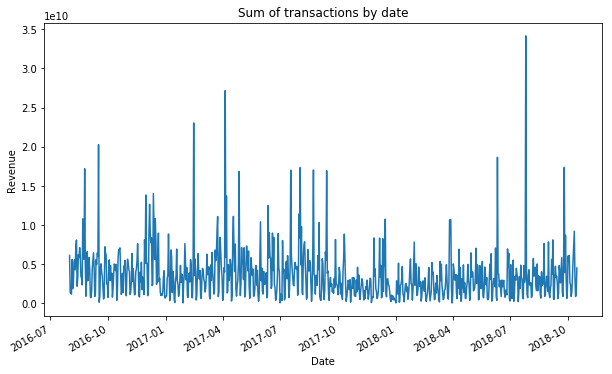

In [55]:
# Plot sum of transactions by date
ax = gr_cnt['sum'].plot.line(figsize=(10,6))
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.set_title('Sum of transactions by date')

Text(0.5, 1.0, 'Count of visitors by date')

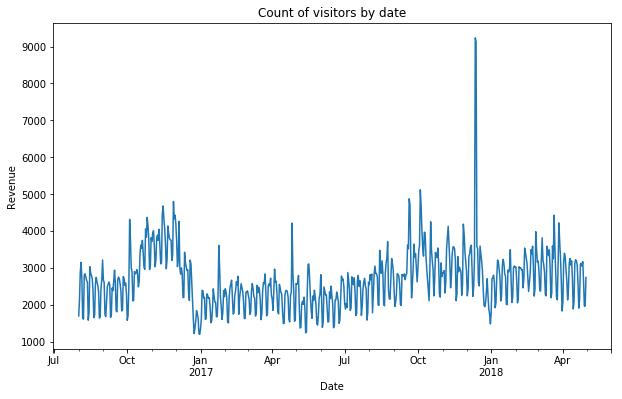

In [56]:
# Plot count of visitors by date
gr_cnt = train_df.groupby('date').count()
ax = gr_cnt['visitNumber'].plot.line(figsize=(10,6))
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.set_title('Count of visitors by date')

Text(0.5, 1.0, 'Number of visits before purchase')

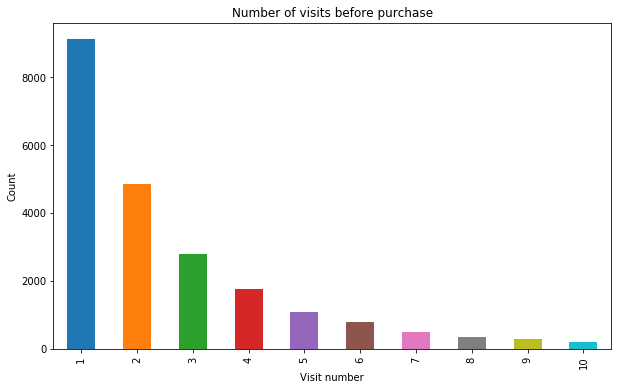

In [57]:
# Plot nubmer of vistits before purchase
gr_cnt = purch.groupby('visitNumber')['visitNumber'].agg(['count'])
ax = gr_cnt['count'].head(10).plot.bar(figsize=(10,6))
ax.set_xlabel('Visit number')
ax.set_ylabel('Count')
ax.set_title('Number of visits before purchase')

In [58]:
# Save for later use
total_df.to_pickle('total_df_1.pkl')

In [59]:
# check number of uniqe entries in each columns designated for one hot encoding
total_df[['channelGrouping', 'device.deviceCategory',
            'device.operatingSystem','geoNetwork.subContinent',
            'trafficSource.medium']].nunique()

channelGrouping             8
device.deviceCategory       3
device.operatingSystem     26
geoNetwork.subContinent    23
trafficSource.medium        7
dtype: int64

In [60]:
# one hot encode selected columns
def one_hot_cols(df):
    cols = ['channelGrouping', 'device.deviceCategory',
            'device.operatingSystem','geoNetwork.subContinent',
            'trafficSource.medium']
    
    temp = pd.concat([pd.get_dummies(df[col]) for col in cols], axis=1)
    
    df = pd.concat([df, temp], axis=1)
    
    cols.append('(not set)')
    
    df.drop(columns=cols, axis=1, inplace=True)
    return df

total_df = one_hot_cols(total_df)

In [61]:
# report dataframe shape after one hot encoding
total_df.shape

(2109926, 74)

In [62]:
#Strip whitespace in columns
total_df.columns = total_df.columns.str.replace(" ","")

In [63]:
# save for later use
total_df.to_pickle('total_df_2.pkl')

In [64]:
# load data
total_df = pd.read_pickle('total_df_2.pkl')
train_date_max = dt.date(2018, 4,30)

In [65]:
# convert log each transaction
total_df['totals.transactionRevenue'] = np.log1p(total_df['totals.transactionRevenue'])

In [66]:
total_df['totals.bounces'] = pd.to_numeric(total_df['totals.bounces'])
total_df['totals.hits'] = pd.to_numeric(total_df['totals.hits'])
total_df['totals.newVisits'] = pd.to_numeric(total_df['totals.newVisits'])
total_df['totals.pageviews'] = pd.to_numeric(total_df['totals.pageviews'])
total_df['trafficSource.isTrueDirect'] = pd.to_numeric(total_df['trafficSource.isTrueDirect'])

In [67]:
# split total data back to training, test and subsampled of training data
train_df = total_df.loc[total_df.date <= train_date_max]
#train_obs = test_df.shape[0] * 2
train_sub_df = train_df.sample(n=test_df.shape[0] * 2, random_state=42,)
test_df = total_df.loc[total_df.date > train_date_max]
print (train_df.date.max(), test_df.date.max())

/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """


2018-04-30 00:00:00 2018-10-15 00:00:00


In [68]:
## split data into features and labels for training, test and training_sub data
y_cols = ['totals.transactionRevenue', 'fullVisitorId', 'date', 'totals.hits']

y_train = train_df[y_cols[0]]
y_train_sub = train_sub_df[y_cols[0]]

X_train_sub = train_sub_df.drop(y_cols, axis=1)
X_train = train_df.drop(y_cols, axis=1)


y_test = test_df[y_cols[0]].values
X_test = test_df.drop(y_cols, axis=1)

print (X_train.shape)
print (train_df.shape)

(1708337, 70)
(1708337, 74)


In [69]:
# Create a benchmark, 
# Define, train and predict with Bagging regressor
reg = BaggingRegressor().fit(X_train, y_train)

%time pred = reg.predict(X_test)
np.sqrt(mean_squared_error(pred, y_test))

CPU times: user 4.72 s, sys: 2.19 s, total: 6.91 s
Wall time: 1.83 s


1.7425085793427402

In [70]:
# credit to https://blog.cambridgespark.com for paramter tuning.

In [71]:
# load data in to XGBoost dmatrices
dtrain_sub = xgb.DMatrix(X_train_sub, label=y_train_sub)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [72]:
# define initial params for XGboost
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear',
    'eval_metric': 'rmse',
}
# define number for boost rounds
num_boost_round = 999

In [73]:
# train an initial model
init_model = xgb.train(
    params,
    dtrain_sub,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=5
)

#print(params)

[16:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	Test-rmse:1.79044
Will train until Test-rmse hasn't improved in 5 rounds.
[16:52:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	Test-rmse:1.72296
[16:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	Test-rmse:1.68756
[16:52:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[3]	Test-rmse:1.66949
[16:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	Test-rmse:1.65989
[16:52:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[5]	Test-rmse:1.6557
[16:52:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[6]	Test-rmse:1.65285


In [74]:
#define values to iterate over for max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,12, 2)
    for min_child_weight in range(6,12, 2)
]
print (gridsearch_params)

[(6, 6), (6, 8), (6, 10), (8, 6), (8, 8), (8, 10), (10, 6), (10, 8), (10, 10)]


In [75]:
# Define initial scores best parameters 
min_rmse = float("Inf")
best_params = None

#Iterate over parameteres to search 
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    #update params
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
# Load selected paramtere pair into cross validation and run
    cv_results = xgb.cv(params,
                              dtrain_sub,
                              num_boost_round=num_boost_round,
                              seed=42,
                              nfold=5,metrics={'rmse'},
                              early_stopping_rounds=3)
    
    # after each cross validation is finished save best score 
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    #if score improved save score, params
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=6, min_child_weight=6
[16:53:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:53:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:53:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:53:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:53:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:53:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:53:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:53:59] src/tree/updater_prune.cc:74: tree pruning en

/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	RMSE 1.5689744000000003 for 10 rounds
CV with max_depth=6, min_child_weight=8
[16:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[16:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:57:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:57:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[16:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:57:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[16:57:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:57:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[16:57:38] src/tr

[17:00:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:01:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:01:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:01:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:01:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:01:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:01:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[17:04:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[17:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=8
[17:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=8
[17:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=8
[17:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=8
[17:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=8
[17:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[17:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=8
[17:05:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned no

[17:09:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=8
[17:09:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[17:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=8
[17:09:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[17:09:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=8
[17:09:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[17:09:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[17:09:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=8
[17:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned no

[17:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[17:14:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[17:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=8
[17:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[17:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=8
[17:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[17:14:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=8
[17:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[17:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned no

[17:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 0 pruned nodes, max_depth=10
[17:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[17:19:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 766 extra nodes, 0 pruned nodes, max_depth=10
[17:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=10
[17:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 pruned nodes, max_depth=10
[17:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[17:19:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 0 pruned nodes, max_depth=10
[17:20:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned nodes, max_depth=10
[17:20:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 p

[17:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1060 extra nodes, 0 pruned nodes, max_depth=10
[17:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1076 extra nodes, 0 pruned nodes, max_depth=10
[17:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1044 extra nodes, 0 pruned nodes, max_depth=10
[17:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1088 extra nodes, 0 pruned nodes, max_depth=10
[17:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1062 extra nodes, 0 pruned nodes, max_depth=10
[17:25:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned nodes, max_depth=10
[17:26:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1028 extra nodes, 0 pruned nodes, max_depth=10
[17:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1028 extra nodes, 0 pruned nodes, max_depth=10
[17:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1052 extra n

In [76]:
# update paramteres.
params['max_depth'] = 6
params['min_child_weight'] = 6

In [77]:
print (params)

{'max_depth': 6, 'min_child_weight': 6, 'eta': 0.3, 'subsample': 1, 'colsample_bytree': 1, 'objective': 'reg:linear', 'eval_metric': 'rmse'}


In [78]:
#define values to iterate over
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(8,11)]
    for colsample in [i/10. for i in range(8,11)]
]

print (gridsearch_params)

[(0.8, 0.8), (0.8, 0.9), (0.8, 1.0), (0.9, 0.8), (0.9, 0.9), (0.9, 1.0), (1.0, 0.8), (1.0, 0.9), (1.0, 1.0)]


In [79]:
# Define initial scores
min_rmse = float("Inf")
best_params = None

#Iterate over parameteres to search
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    #update params
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Load selected paramtere pair into cross validation and run
    cv_results = xgb.cv(
        params,
        dtrain_sub,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    # after each cross validation is finished save best score 
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    #if score improved save score, params
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
[17:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:29:40] src/tree/updater_prune.cc:74: tree pruning end, 

[17:32:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[17:32:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[17:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[17:33:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[17:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6


/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	RMSE 1.5689744000000003 for 10 rounds
CV with subsample=1.0, colsample=0.9
[17:33:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[17:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:33:52] src/tree/

[17:36:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:36:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[17:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[17:36:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[17:36:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[17:37:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[17:37:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[17:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[17:37:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max

[17:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[17:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[17:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[17:40:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:40:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes,

[17:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:44:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:44:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[17:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[17:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned no

[17:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:47:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[17:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[17:48:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[17:48:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned no

[17:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[17:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:51:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[17:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:51:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:51:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned no

[17:54:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[17:55:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:55:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:55:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[17:55:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[17:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned no

	RMSE 1.5697142 for 11 rounds
CV with subsample=0.8, colsample=0.9
[17:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:59:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[17:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[17:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[17:59:27] src/tree/updater_p

[18:02:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[18:02:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
	RMSE 1.5706060000000002 for 9 rounds
CV with subsample=0.8, colsample=0.8
[18:02:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:03:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[18:03:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[18:03:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:03:17] src/tree/updat

[18:06:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[18:06:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[18:06:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:06:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:06:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[18:06:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[18:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, 

In [80]:
# save optimal paramaters to models parameters
params['subsample'] = 1.
params['colsample_bytree'] = .9

In [81]:
# Define initial scores
min_rmse = float("Inf")
best_params = None

#Iterate over parameteres to search
for eta in [.1, .05, .03]:
    print("CV with eta={}".format(eta))
    
    #update param
    params['eta'] = eta
     # Load selected paramtere pair into cross validation and run
    cv_results = xgb.cv(params,dtrain_sub,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['rmse'],early_stopping_rounds=5)
    
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    #if score improved save score, params
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CV with eta=0.1
[18:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:07:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:07:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra no

[18:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:10:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:10:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:10:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:10:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:11:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned no

[18:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:14:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:14:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nod

/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


	MAE 1.5686947999999998 for 35 rounds

CV with eta=0.05
[18:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:16:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:16:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:17:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:17:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:17:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:17:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:17:14] src/tree/updater_prune.cc:74:

[18:20:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:20:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:20:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:20:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[18:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:23:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned no

[18:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:27:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:27:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nod

[18:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:30:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned no

[18:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:33:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:33:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[18:33:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:33:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[18:33:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:33:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned no

[18:37:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[18:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[18:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:37:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:37:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
	MAE 1.5685588000000001 for 83 rounds

CV with eta=0.03
[18:37:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:37:37] src/tree/updater_prune.cc:74: tre

[18:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:41:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

[18:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:44:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:44:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:44:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:44:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned no

[18:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:47:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[18:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:48:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nod

[18:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[18:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:51:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:51:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[18:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nod

[18:54:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[18:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[18:54:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[18:54:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:54:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[18:54:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[18:54:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nod

[18:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[18:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[18:57:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[18:58:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[18:58:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[18:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[18:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes

[19:01:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[19:01:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:01:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:01:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:01:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:01:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[19:01:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:01:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nod

[19:04:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[19:04:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:04:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:04:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[19:04:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[19:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[19:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[19:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes

[19:07:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[19:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[19:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[19:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[19:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[19:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[19:08:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[19:08:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes

In [82]:
#update params
params['eta'] = 0.03
print (params)

{'max_depth': 6, 'min_child_weight': 6, 'eta': 0.03, 'subsample': 1.0, 'colsample_bytree': 0.9, 'objective': 'reg:linear', 'eval_metric': 'rmse'}


In [83]:
# train final model on full train set. 
XG_Google = xgb.train(params,dtrain,num_boost_round=num_boost_round,evals=[(dtest, "Test")],early_stopping_rounds=10)

[19:11:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	Test-rmse:1.90339
Will train until Test-rmse hasn't improved in 10 rounds.
[19:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[1]	Test-rmse:1.88977
[19:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[2]	Test-rmse:1.87676
[19:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	Test-rmse:1.86437
[19:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[4]	Test-rmse:1.85269
[19:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[5]	Test-rmse:1.84164
[19:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[6]	Test-rmse:1.8311

[19:18:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[60]	Test-rmse:1.65707
[19:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[61]	Test-rmse:1.65649
[19:18:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[62]	Test-rmse:1.656
[19:18:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[63]	Test-rmse:1.65552
[19:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[64]	Test-rmse:1.65509
[19:19:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[65]	Test-rmse:1.65461
[19:19:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[66]	Test-rmse:1.65413
[19:19:19] src/tree/updater_prune.cc:74: tree prun

[120]	Test-rmse:1.64701
[19:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[121]	Test-rmse:1.64697
[19:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[122]	Test-rmse:1.64697
[19:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[123]	Test-rmse:1.64695
[19:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[124]	Test-rmse:1.64692
[19:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[125]	Test-rmse:1.64692
[19:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[126]	Test-rmse:1.64691
[19:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[127]	Test-rmse:1.64687
[19:26:52] src/tr

In [84]:
#Print RMSE Score on test data before adjustment
%time prediction = XG_Google.predict(dtest)
rmse = np.sqrt(mean_squared_error(prediction, y_test))
print ('RMSE on before adjustment set : {}'. format(rmse))

CPU times: user 8.18 ms, sys: 1.64 ms, total: 9.82 ms
Wall time: 7.79 ms
RMSE on before adjustment set : 1.6466292996834369


In [85]:
# Unfortunatly XGboost predicts minus revenue,  change this to 0
for i in range(0, len(prediction)):
    if prediction[i] < 0:
        prediction[i] = 0.0

In [86]:
rmse = np.sqrt(mean_squared_error(prediction, y_test))
print ('Final RMSE : {}'. format(rmse))

Final RMSE : 1.6466193681447938


In [87]:
#save model
XG_Google.save_model("XG_google.model")

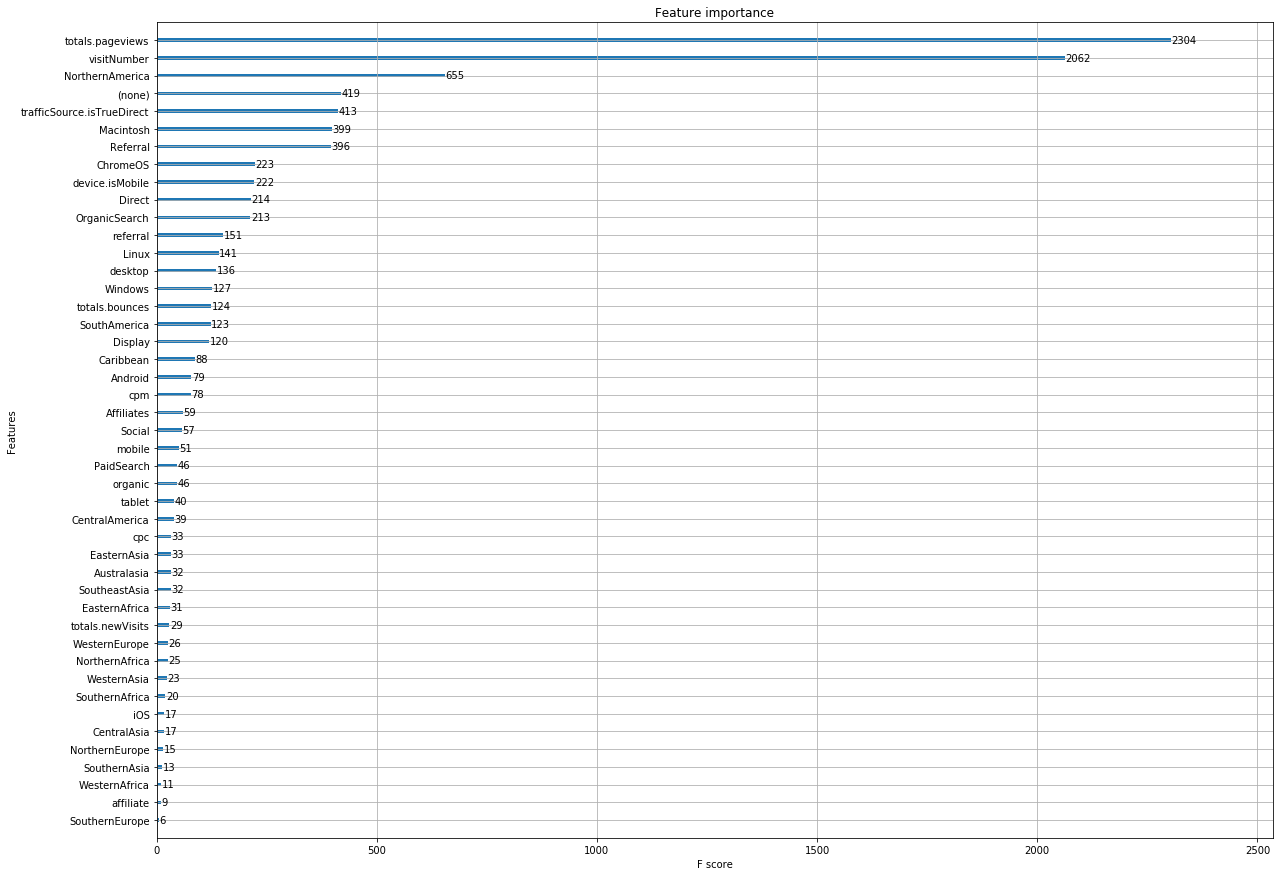

In [88]:
# Plot feature importance
plt.figure(figsize=(20,15))
xgb.plot_importance(XG_Google, ax=plt.gca())

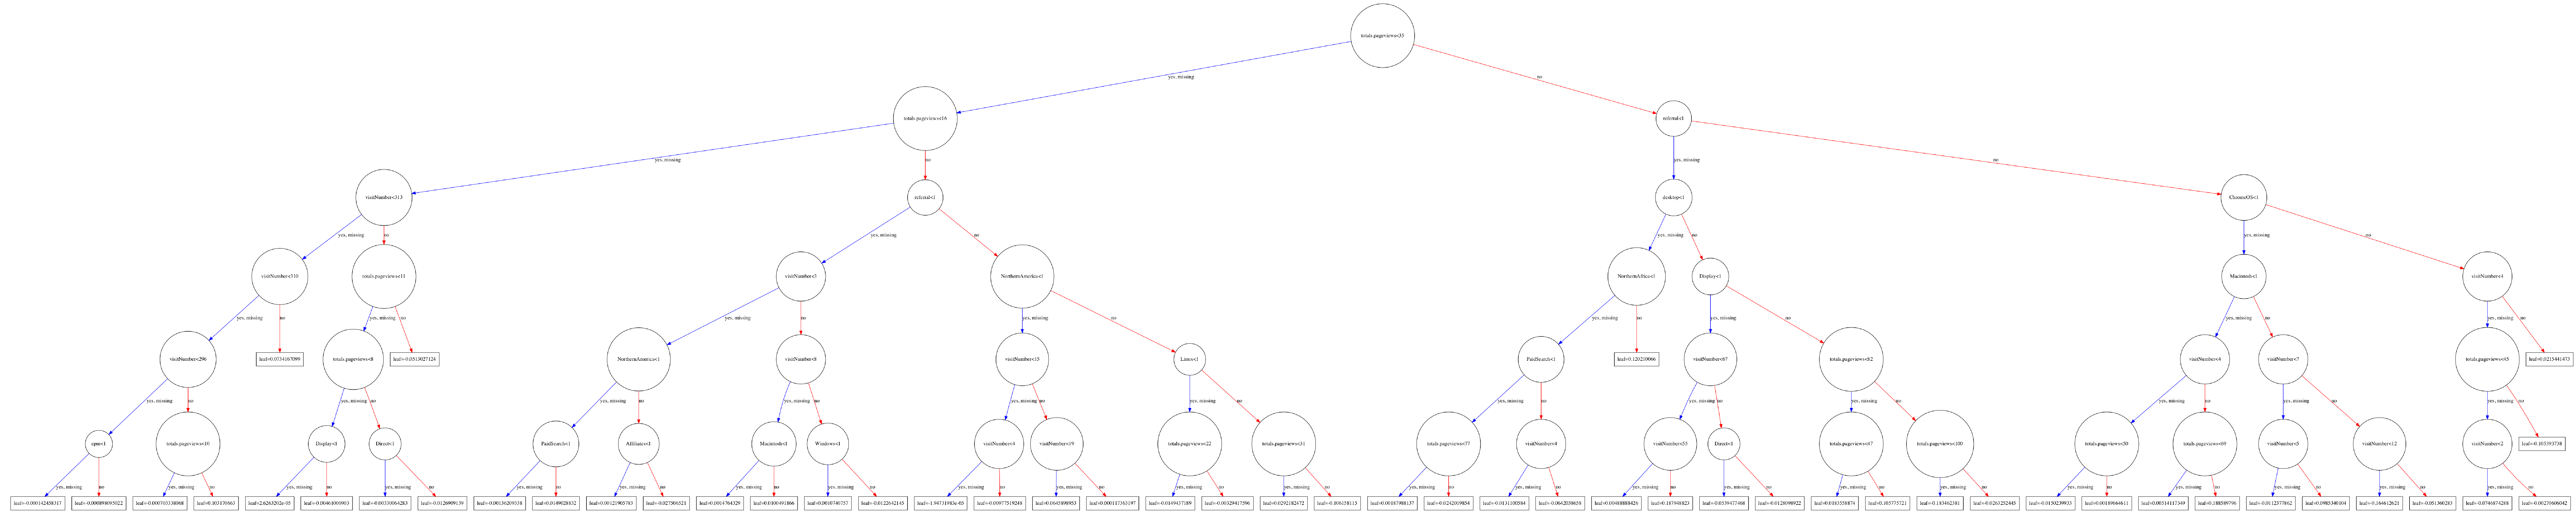

In [89]:
import graphviz
# plot decision tree
plt.figure(figsize=(200,150))
xgb.plot_tree(XG_Google, ax=plt.gca(), num_trees=XG_Google.best_iteration)